In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import pickle
from itertools import compress
warnings.filterwarnings('ignore')
% matplotlib inline

In [2]:
from model_generator import *

### Generate df

In [3]:
paths_dict_band = json.load(open('inputs_json/paths_dict_band.json', 'r'))

In [4]:
band = generate_df(paths_dict_band, 'band', '2016')

In [5]:
df = band.return_completed_df()

In [6]:
name_list_24 = ['band']

In [7]:
feature_eng_df = band.return_df_feature_engineering(name_list_24)

In [8]:
band_mean_vol_aemet = pd.read_csv('aemet/band_mean_vol_pred_aemet.csv', encoding='latin1', index_col=0)

In [9]:
final_df = feature_eng_df.merge(band_mean_vol_aemet, how='left', left_index=True, right_index=True)

In [10]:
for feature in ['pred_band_mean_aemet', 'pred_band_vol_aemet']:
    final_df[feature].fillna(method='pad', inplace=True)

In [11]:
features_list = json.load(open('inputs_json/feature_list_band_wo_hour_day_season.json', 'r'))

In [12]:
len(features_list)

87

### Train model

In [13]:
lgbm_model_grouped = train_model(df=final_df, output='band', features_list=features_list,
                                n_folds=5, cv_type='group')

In [14]:
rf_model_grouped = train_model(df=final_df, output='band', features_list=features_list,
                                n_folds=5, cv_type='group')

In [15]:
knn_model_grouped = train_model(df=final_df, output='band', features_list=features_list,
                                n_folds=5, cv_type='group')

In [16]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
pipeline = LGBMRegressor(num_leaves=60, learning_rate=0.08, n_estimators=1000, seed=0)
pipeline_group = LGBMRegressor(num_leaves=40, learning_rate=0.05, n_estimators=700, seed=0)
rf_pipeline_group = make_pipeline(Imputer(strategy='median'),
                          RandomForestRegressor(n_estimators=80, max_depth=9, 
                                                max_features='sqrt', max_leaf_nodes=200, 
                                                n_jobs=-1, random_state=0, min_samples_split=80,
                                               min_samples_leaf=25))
knn_pipeline_group = make_pipeline(Imputer(strategy='median'),StandardScaler(),
                                  KNeighborsRegressor(n_neighbors=22, weights='uniform', 
                                                      leaf_size=30,p=2, n_jobs=-1))

In [17]:
lgbm_model_grouped.obtain_cv_score(pipeline_group)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 4.3815 +- 0.2877
Mean squared error: 43.1448 +- 12.7968


In [18]:
rf_model_grouped.obtain_cv_score(rf_pipeline_group)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 4.8643 +- 0.2041
Mean squared error: 51.9056 +- 11.7778


In [19]:
knn_model_grouped.obtain_cv_score(knn_pipeline_group)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 4.8695 +- 0.1810
Mean squared error: 53.1586 +- 10.9128


In [20]:
lgbm_model_grouped.obtain_train_test_error(pipeline_group)

Train MAE: 2.11319082621, Train MSE: 8.90240005376
Test MAE: 4.74245692024, Test MSE: 61.2398316454


In [21]:
rf_model_grouped.obtain_train_test_error(rf_pipeline_group)

Train MAE: 4.0336001617, Train MSE: 36.1376236867
Test MAE: 5.26502277571, Test MSE: 68.2381569669


In [22]:
knn_model_grouped.obtain_train_test_error(knn_pipeline_group)

Train MAE: 3.7953835936, Train MSE: 32.2361494985
Test MAE: 5.33373114709, Test MSE: 78.2880911961


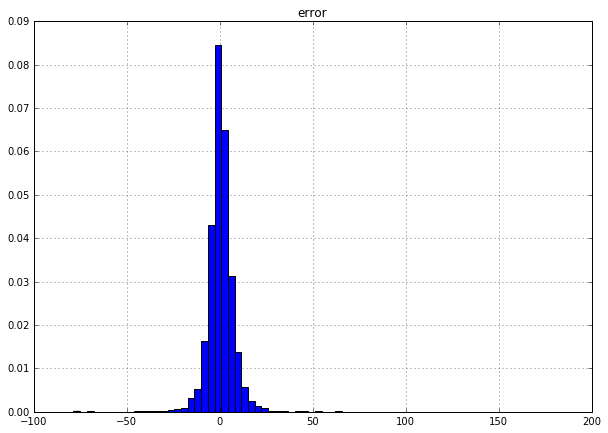

In [23]:
lgbm_model_grouped.plot_histogram_error()

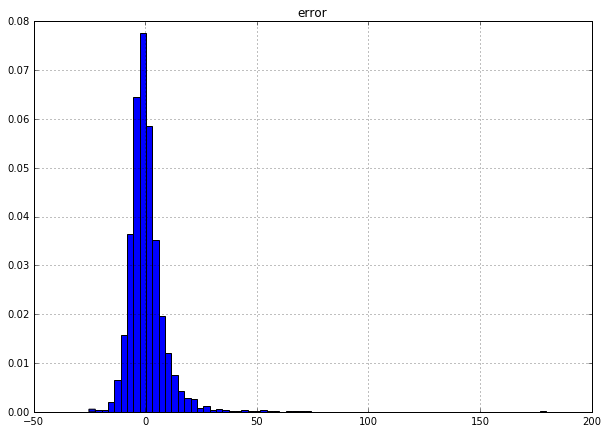

In [24]:
rf_model_grouped.plot_histogram_error()

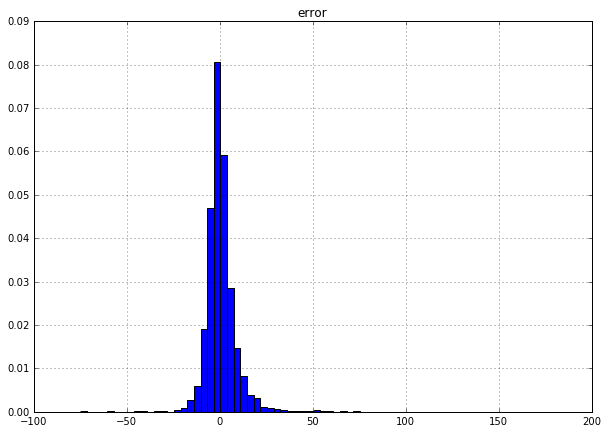

In [25]:
knn_model_grouped.plot_histogram_error()

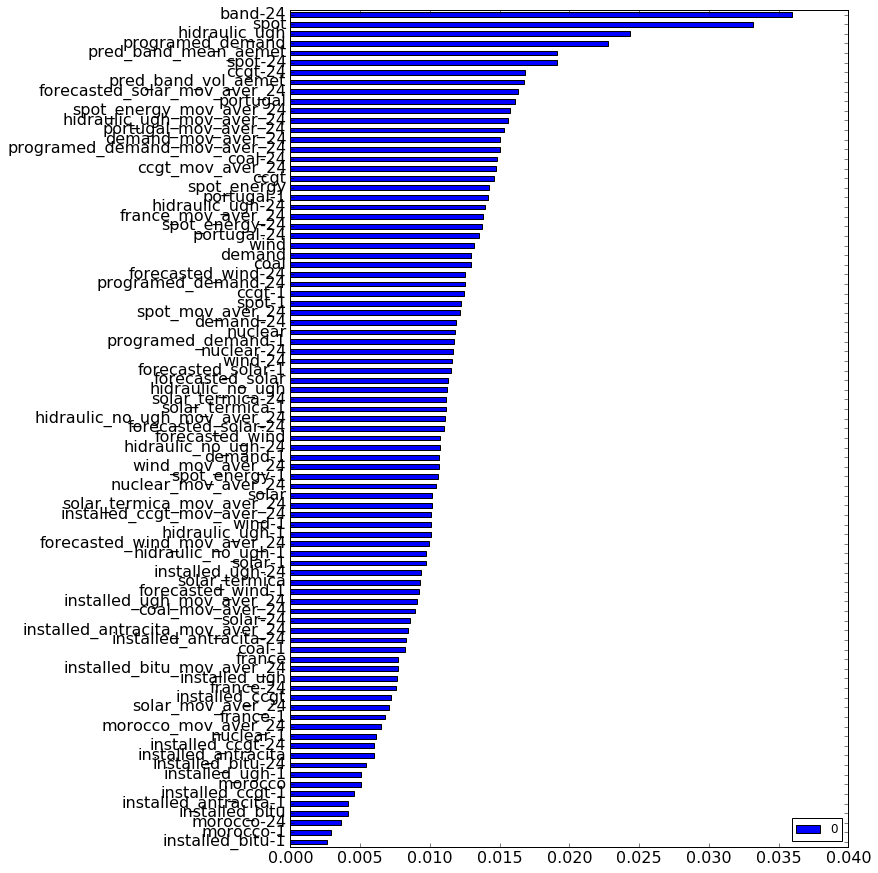

In [26]:
lgbm_model_grouped.get_feature_importance()

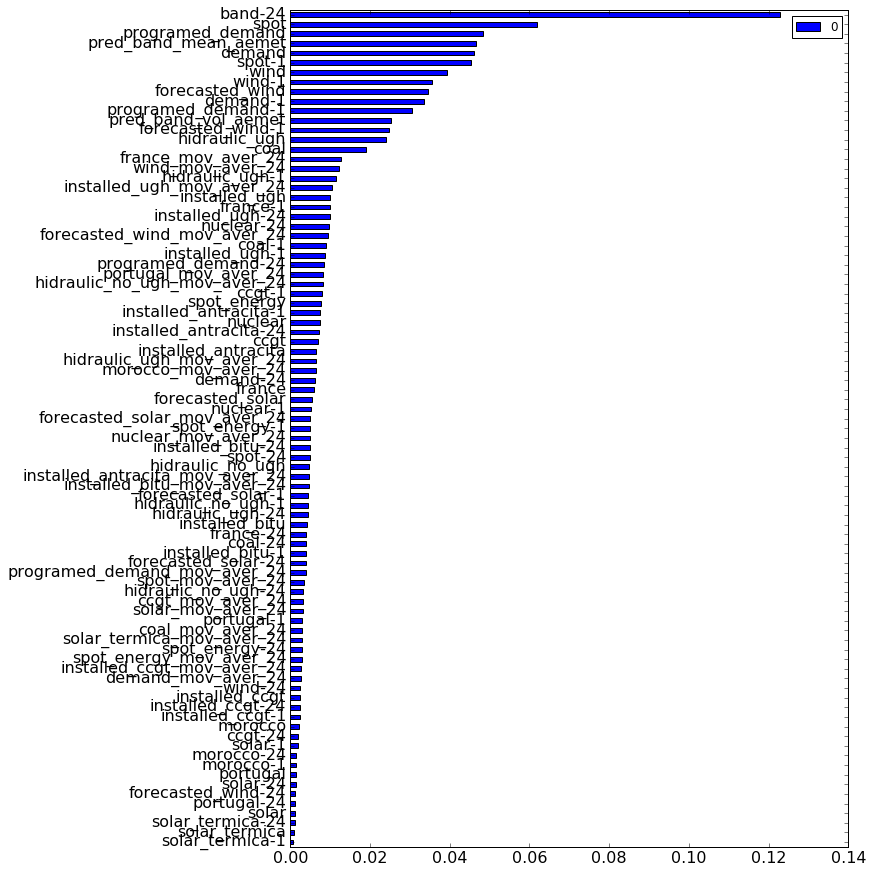

In [27]:
rf_model_grouped.get_feature_importance()

In [28]:
lgbm_metamodel = metamodel(features=features_list, pipeline=pipeline_group, n_folds=5, 
                           num_cv=1, cv_type='group',
                           metric={'mae':mean_absolute_error, 'mse':mean_squared_error})

In [29]:
date, oos_lgbm = lgbm_metamodel.get_oos_cv_predictions(x_train=final_df.reset_index(),
                                                      y_train=final_df['band'],
                                                      index_col='date_hour')

CV number:  1
Acting on fold 1 of 1
Acting on fold 2 of 1
Acting on fold 3 of 1
Acting on fold 4 of 1
Acting on fold 5 of 1
mse on 1 CV: 45.6318 +- 19.6919
mae on 1 CV: 4.4168 +- 0.4724


In [30]:
rf_metamodel = metamodel(features=features_list, pipeline=rf_pipeline_group, n_folds=5, 
                         num_cv=1, cv_type='group',
                         metric={'mae': mean_absolute_error, 'mse':mean_squared_error})

In [31]:
date, oos_rf = rf_metamodel.get_oos_cv_predictions(x_train=final_df.reset_index(),
                                                  y_train=final_df['band'],
                                                  index_col='date_hour')

CV number:  1
Acting on fold 1 of 1
Acting on fold 2 of 1
Acting on fold 3 of 1
Acting on fold 4 of 1
Acting on fold 5 of 1
mse on 1 CV: 53.5881 +- 19.6724
mae on 1 CV: 4.8802 +- 0.5504


In [32]:
knn_metamodel = metamodel(features=features_list, pipeline=knn_pipeline_group, n_folds=5,
                         num_cv=1, cv_type='group',
                         metric={'mae': mean_absolute_error, 'mse':mean_squared_error})

In [33]:
date, oos_knn = knn_metamodel.get_oos_cv_predictions(x_train=final_df.reset_index(),
                                                  y_train=final_df['band'],
                                                  index_col='date_hour')

CV number:  1
Acting on fold 1 of 1
Acting on fold 2 of 1
Acting on fold 3 of 1
Acting on fold 4 of 1
Acting on fold 5 of 1
mse on 1 CV: 55.7229 +- 24.2216
mae on 1 CV: 4.8653 +- 0.5343


In [43]:
stack_df = pd.DataFrame({'lgbm': oos_lgbm, 'rf':oos_rf, 'knn': oos_knn, 'band': final_df['band']}, index=date)

In [44]:
pipeline_stack = make_pipeline(Imputer(strategy='median'), StandardScaler(), SelectFromModel(Lasso(alpha=0.1, random_state=0)),
                               Ridge(alpha=1, random_state=0))

In [45]:
stack_df['hour'] = stack_df.index.hour
stack_df[pd.get_dummies(stack_df['hour'], drop_first=True).columns.tolist()] = pd.get_dummies(stack_df['hour'], drop_first=True)

In [46]:
weekday_dict = {
            0:'L', 1:'M', 2:'X', 3:'J', 4:'V', 5:'S', 6:'D' 
}
stack_df['date'] = pd.to_datetime(stack_df.index.date)
stack_df['weekday'] = pd.to_datetime(stack_df['date']).dt.dayofweek
stack_df.replace({'weekday':weekday_dict}, inplace=True)

In [47]:
stack_df[pd.get_dummies(stack_df['weekday'], drop_first=True).columns.tolist()] = pd.get_dummies(stack_df['weekday'], drop_first=True)

In [48]:
features_stack_final = [ element for element in stack_df.columns.tolist() if element not in ['band', 'hour', 'date', 'weekday']]

In [49]:
stack_model = train_model(stack_df, 'band', features_stack_final, n_folds=5, cv_type='group')

In [50]:
stack_model.obtain_cv_score(pipeline_stack)

Acting on fold 1
Acting on fold 2
Acting on fold 3
Acting on fold 4
Acting on fold 5
Mean absolute error: 4.1689 +- 0.2665
Mean squared error: 38.7898 +- 9.1259


In [51]:
stack_model.obtain_train_test_error(pipeline_stack)

Train MAE: 4.13779822743, Train MSE: 38.1050986792
Test MAE: 4.63952955782, Test MSE: 59.6645793524


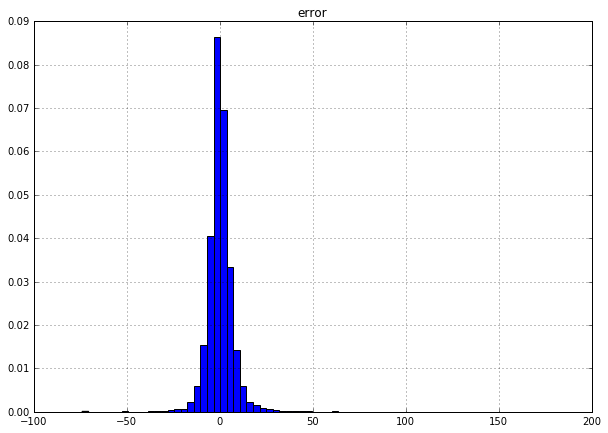

In [52]:
stack_model.plot_histogram_error()

In [53]:
stack_model.get_feature_importance()

                   0
intercept  19.306246
knn         3.402009
lgbm        6.303704
rf          0.741915
1           0.282859
3          -0.130422
4          -0.354057
5          -0.294059
6           0.251205
9           0.146192
10          0.132650
12         -0.070033
14          0.301553
15          0.350942
20         -0.074645
23          0.147917
J           0.168502
S           0.213777
X           0.199960


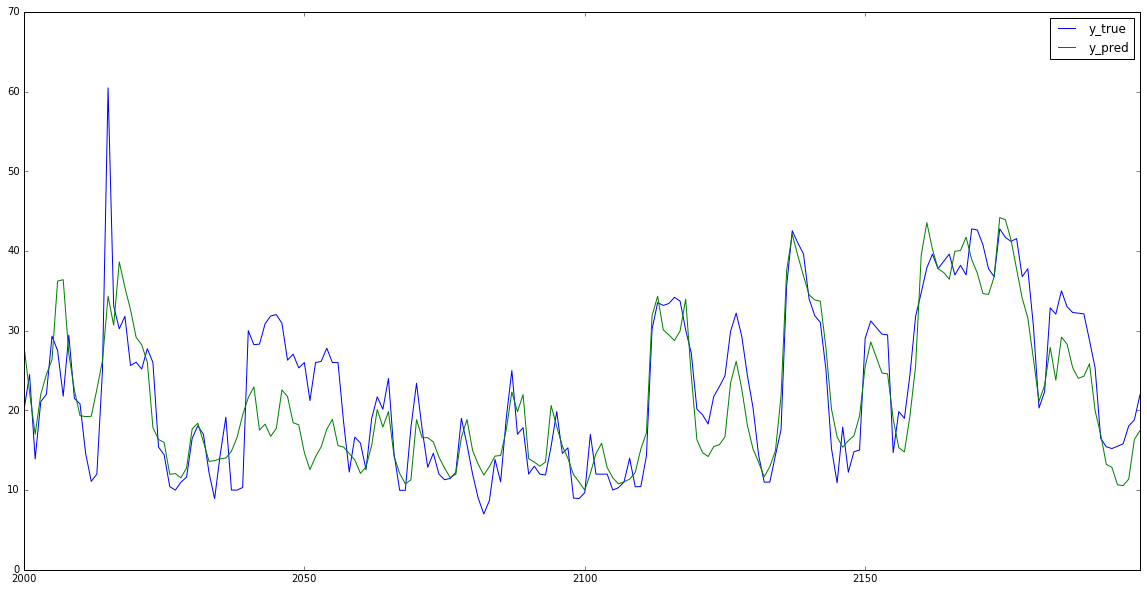

In [54]:
stack_model.errors_df[['y_true', 'y_pred']].iloc[2000:2200].plot(figsize=(20,10))

In [55]:
residuals_lgbm = lgbm_model_grouped.get_log_residuals()

In [56]:
residuals_knn = knn_model_grouped.get_log_residuals()

In [57]:
residuals_rf = rf_model_grouped.get_log_residuals()

In [58]:
residuals_stack = stack_model.get_log_residuals()

### Export residuals and model

In [59]:
with open('models_p/pipeline_stack.p', 'wb') as f:
    pickle.dump(stack_model.pipeline, f)
    
with open('models_p/lgbm_band_group.p', 'wb') as f:
    pickle.dump(lgbm_model_grouped.pipeline, f)

with open('models_p/knn_band_group.p', 'wb') as f:
    pickle.dump(knn_model_grouped.pipeline, f)    
    
with open('models_p/rf_model_grouped.p', 'wb') as f:
    pickle.dump(rf_model_grouped.pipeline, f)
    
with open('inputs_json/feature_list_band_stack.json', 'w') as f:
    json.dump([str(element) for element in stack_model.features_list], f)

residuals_lgbm.to_json('inputs_json/residuals_band_lgbm_group.json', orient='index', date_format='iso')

residuals_rf.to_json('inputs_json/residuals_rf.json', orient='index', date_format='iso')

residuals_knn.to_json('inputs_json/residuals_knn.json', orient='index', date_format='iso')
    
residuals_stack.to_json('inputs_json/residuals_stack.json',
                              orient='index', date_format='iso')